<a href="https://colab.research.google.com/github/bachaudhry/kaggle_birdCLEF_25/blob/main/BirdCLEF25_04_Iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BirdCLEF 25 - Iterating From Baseline



*   Logging in Gsheets
*   Implementing SpecAugment and MixUp/CutMix on Spectrograms
*   Learning Rate Scheduler and early stopping



In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/Kaggle"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q kaggle
!pip install gspread gspread-dataframe oauth2client

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, gc, random, math, time, copy , zipfile, tarfile, shutil, subprocess, json
from pathlib import Path
from tqdm.notebook import tqdm
import IPython.display as ipd
from IPython.display import display, clear_output
import ipywidgets as widgets

import librosa
import librosa.display
import soundfile as sf

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import torch.amp as amp

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import LabelEncoder

# For logging experiment results to GSheets.
import time, copy, gspread
from gspread_dataframe import set_with_dataframe
from google.colab import auth
from google.auth import default as GoogleAuthDefault

In [4]:
sys.path.append('/content/drive/MyDrive/Kaggle/Bird_CLEF25/utils')
from utils import Config, BirdClefDataset, create_target_tensor, seed_everything, process_gzipped

In [5]:
cfg = Config()
# Path to original train.csv, audio and metadata
cfg.BASE_DATA_PATH = Path("/content/drive/MyDrive/Kaggle/Bird_CLEF25/data/birdclef-2025")
# Path to npy files
cfg.PRECOMPUTED_SPECS_PATH = Path("/content/drive/MyDrive/Kaggle/Bird_CLEF25/data/precomputed-specs-np-zipped")
# Path to local specs
#cfg.LOCAL_SPECS_PATH = Path("/content/precomputed_spectrograms")
# Training meta data
cfg.TRAIN_METADATA_PATH = Path("/content/drive/MyDrive/Kaggle/Bird_CLEF25/data/birdclef-2025/train.csv")

In [6]:
# --- Set Device & Seed ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
seed_everything(cfg.SEED)

Using device: cuda
Seeded everything with: 42


In [7]:
if cfg.NUM_WORKERS > 0:
    try:
        current_context = mp.get_context(None)
        if not isinstance(current_context, mp.SpawnContext):
             mp.set_start_method('spawn', force=True)
             print("Set multiprocessing start method to 'spawn'.")
        else:
             print("Multiprocessing start method already set to 'spawn'.")
    except RuntimeError as e:
        print(f"Could not set start method (might be already set or first run): {e}")

Set multiprocessing start method to 'spawn'.


In [8]:
# --- Load Metadata ---
if not cfg.TRAIN_METADATA_PATH.exists():
    print(f"ERROR: Metadata file not found at {cfg.TRAIN_METADATA_PATH}")
    # Stop execution or handle
else:
    train_df = pd.read_csv(cfg.TRAIN_METADATA_PATH)
    print(f"Train metadata loaded. Shape: {train_df.shape}")

Train metadata loaded. Shape: (28564, 13)


In [9]:
# Download zipped folder and extract to local # One time per setup
input_path = "/content/drive/MyDrive/Kaggle/Bird_CLEF25/data/precomputed-specs-np-zipped"
local_extract = process_gzipped(input_path)

Copying precomputed-specs-np-zipped from Drive to Colab...
Extracting precomputed-specs-np-zipped...


Extracting files: 100%|██████████| 187905/187905 [04:58<00:00, 628.82it/s]


Operation completed successfully!


In [9]:
# Update precomputed specs path
#cfg.PRECOMPUTED_SPECS_PATH = cfg.LOCAL_SPECS_PATH
# Run check
local_specs_path = Path("/content/temp_data/extracted/kaggle/working/precomputed_specs_np")
all_precomputed_files = list(local_specs_path.glob("*.npy"))
print(f"Found {len(all_precomputed_files)} precomputed .npy files.")

Found 187904 precomputed .npy files.


In [10]:
cfg.PRECOMPUTED_SPECS_PATH = local_specs_path

In [11]:
# Create label mappings
unique_labels = sorted(train_df['primary_label'].unique())
cfg.NUM_CLASSES = len(unique_labels)
cfg.LABEL_TO_INT = {label: i for i, label in enumerate(unique_labels)}
cfg.INT_TO_LABEL = {i: label for label, i in cfg.LABEL_TO_INT.items()}
train_df['primary_label_int'] = train_df['primary_label'].map(cfg.LABEL_TO_INT)
print(f"{cfg.NUM_CLASSES} unique classes found.")

206 unique classes found.




---



This next step involves the creation of a manifest file to make the process of ensuring that preprocessed spectrograms are mapped to their respective originals in the train DF metadata file.

If done correctly this cell will only need to be run once so that a `manifest.csv` file is created and stored in Google Drive. Afterwards, this step can be commented out and will be replaced with a new cell to simply load the manifest file from source.



---



In [12]:
# Load manifest data
manifest_load_path = Path("/content/drive/MyDrive/Kaggle/Bird_CLEF25/data/manifest.csv")
if manifest_load_path.exists():
    manifest_df = pd.read_csv(manifest_load_path)
    print(f"Manifest loaded from {manifest_load_path}")
    print(manifest_df.head(15))

    # Ensure correct data types
    manifest_df['clip_index'] = manifest_df['clip_index'].astype(int)
    manifest_df['primary_label_int'] = manifest_df['primary_label_int'].astype(int)

    clip_samples = manifest_df.to_dict('records') # Convert DF rows to list of dicts
    cfg.TOTAL_CLIPS = len(clip_samples)
    print(f"Loaded {cfg.TOTAL_CLIPS} clip samples from mainfest.")
    print("Sample loaded clip_info: ", clip_samples[0] if clip_samples else "N/A")
else:
  print(f"Error: Manifest not found at {manifest_load_path}")
  raise FileNotFoundError(f"Manifest missing: {manifest_load_path}")

Manifest loaded from /content/drive/MyDrive/Kaggle/Bird_CLEF25/data/manifest.csv
          original_filename                  spec_npy_filename  clip_index  \
0       strowl1/XC48736.ogg      strowl1_XC48736.ogg_clip1.npy           1   
1       roahaw/XC113755.ogg      roahaw_XC113755.ogg_clip1.npy           1   
2       bkcdon/XC250791.ogg      bkcdon_XC250791.ogg_clip2.npy           2   
3      bkmtou1/XC821017.ogg    bkmtou1_XC821017.ogg_clip17.npy          17   
4      yebsee1/XC216248.ogg    yebsee1_XC216248.ogg_clip11.npy          11   
5       roahaw/XC925789.ogg     roahaw_XC925789.ogg_clip16.npy          16   
6   grbhaw1/iNat1156713.ogg  grbhaw1_iNat1156713.ogg_clip0.npy           0   
7       grnkin/XC452703.ogg      grnkin_XC452703.ogg_clip1.npy           1   
8      paltan1/XC375634.ogg    paltan1_XC375634.ogg_clip27.npy          27   
9      cotfly1/XC817211.ogg     cotfly1_XC817211.ogg_clip2.npy           2   
10     wbwwre1/XC456410.ogg     wbwwre1_XC456410.ogg_clip0.np

## Training / Validation Split

In [13]:
if 'clip_samples' not in globals() or not clip_samples:
  print("Error: clip_samples is not loaded, run the previous steps first!")
  raise ValueError("clip_samples not loaded. Can't proceed with data splitting.")
else:
  clip_df_for_split = pd.DataFrame(clip_samples)

  # Filter classes with only one sample - for stratification
  label_counts = clip_df_for_split['primary_label_int'].value_counts()
  single_sample_labels = label_counts[label_counts == 1].index.tolist()

  if single_sample_labels:
    print(f"Found {len(single_sample_labels)} classes with only 1 precomputed sample clip.")
    # Classes being removed
    clip_df_filtered = clip_df_for_split[~clip_df_for_split['primary_label_int'].isin(single_sample_labels)].copy()
    removed_count = len(clip_df_for_split) - len(clip_df_filtered)
    print(f"Removed {removed_count} clips belonging to single sample classes")
    print(f"Remaining clips for splitting: {len(clip_df_filtered)}")
  else:
    clip_df_filtered = clip_df_for_split.copy()
    print("No classes with only 1 precomputed sample clip found. No filtering applied.")

  if not clip_df_filtered.empty:
    # Indeces of the filteredd dataframe for splitting
    features = clip_df_filtered.index
    labels = clip_df_filtered['primary_label_int']

    try:
      train_indeces, val_indeces = train_test_split(
          features, # split on the df index
          test_size=0.2,
          random_state=cfg.SEED,
          stratify=labels
      )
      # Train and validation lists of clip info dicts
      train_clip_info = clip_df_filtered.loc[train_indeces].to_dict('records')
      val_clip_info = clip_df_filtered.loc[val_indeces].to_dict('records')

      print(f"Training clips: {len(train_clip_info)}")
      print(f"Validation clips: {len(val_clip_info)}")

      # Verify stratification - check distributions in train and val
      train_labels_dist = pd.Series([d['primary_label_int'] for d in train_clip_info]).value_counts(normalize=True)
      val_labels_dist = pd.Series([d['primary_label_int'] for d in val_clip_info]).value_counts(normalize=True)
      print("Example class proportions: ")

      if cfg.LABEL_TO_INT:
          example_class_name = list(cfg.LABEL_TO_INT.keys())[0] # Get first class name
          example_class_int = cfg.LABEL_TO_INT.get(example_class_name)
          if example_class_int is not None and example_class_int not in single_sample_labels:
              print(f"  Class '{example_class_name}' (Index {example_class_int}):")
              print(f"    Train proportion: {train_labels_dist.get(example_class_int, 0):.4f}")
              print(f"    Valid proportion: {val_labels_dist.get(example_class_int, 0):.4f}")
          else:
              print(f"  Cannot verify example class '{example_class_name}' (not found or was removed).")
      else:
        print("  Label mappings (cfg.LABEL_TO_INT) not available for verification.")

    except ValueError as e:
        print(f"\nError during stratified split: {e}")
        print("This can happen if, even after filtering, some classes have too few members for the split ratio.")
        print("Consider a smaller validation split or further data cleaning if this persists.")
        train_clip_info, val_clip_info = [], [] # Ensure they are empty on error



Found 1 classes with only 1 precomputed sample clip.
Removed 1 clips belonging to single sample classes
Remaining clips for splitting: 187903
Training clips: 150322
Validation clips: 37581
Example class proportions: 
  Class '1139490' (Index 0):
    Train proportion: 0.0002
    Valid proportion: 0.0002


## Data Loaders

In [33]:
torch.cuda.empty_cache()

In [14]:
cfg.BATCH_SIZE = 512 # test 256 if memory allows
cfg.NUM_WORKERS = 2 # test 8 if config allows

# For Specaugment - tune as needed
FREQ_MASK_PARAM = 12
TIME_MASK_PARAM = 25

In [15]:
# Ensure time steps is correctly calculated from the precomputation parameters
calculated_time_steps = math.floor(cfg.TARGET_SAMPLES / cfg.HOP_LENGTH) + 1
calculated_time_steps

313

In [16]:
train_dataset = BirdClefDataset(
    train_clip_info,
    cfg.PRECOMPUTED_SPECS_PATH,
    cfg.NUM_CLASSES,
    cfg.N_MELS,
    calculated_time_steps,
    augmentations=None, # For custom augmentations
    use_spec_augment=True, # enable specaugment for training set
    freq_mask_param=FREQ_MASK_PARAM,
    time_mask_param=TIME_MASK_PARAM
)

val_dataset = BirdClefDataset(
    val_clip_info,
    cfg.PRECOMPUTED_SPECS_PATH,
    cfg.NUM_CLASSES,
    cfg.N_MELS,
    calculated_time_steps,
    augmentations=None,
    use_spec_augment=False
)

In [17]:
print(f"Train Dataset size: {len(train_dataset)}")
print(f"Validation Dataset size: {len(val_dataset)}")

Train Dataset size: 150322
Validation Dataset size: 37581


In [18]:
train_loader = DataLoader(
    train_dataset,
    cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True,
    drop_last=False
)

print(f"DataLoaders created. Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

DataLoaders created. Train batches: 293, Val batches: 74


In [19]:
# --- Dataloaders Container ---
class BirdDataLoaders:
    def __init__(self, train_dl, valid_dl, device):
        self.train = train_dl
        self.valid = valid_dl
        self.device = device
    @property
    def num_classes(self): return self.train.dataset.num_classes if self.train.dataset else 0

dataloaders = BirdDataLoaders(train_loader, val_loader, device)
print(f"BirdDataLoaders container created. Target device: {dataloaders.device}")

BirdDataLoaders container created. Target device: cuda


In [20]:
try:
    spec_batch, label_batch = next(iter(train_loader))
    print(f"  Spectrogram batch shape: {spec_batch.shape}")
    print(f"  Label batch shape: {label_batch.shape}")
    print(f"  Spectrogram device: {spec_batch.device}") # Expect 'cpu'
    print(f"  Spectrogram dtype: {spec_batch.dtype}")
    print(f"  Label device: {label_batch.device}")     # Expect 'cpu'
    print(f"  Label dtype: {label_batch.dtype}")
except Exception as e:
    print(f"ERROR fetching batch from DataLoader: {e}")
    print("Common issues: issues in Dataset __getitem__, multiprocessing setup, or data corruption.")
    import traceback
    traceback.print_exc()

  Spectrogram batch shape: torch.Size([512, 128, 313])
  Label batch shape: torch.Size([512, 206])
  Spectrogram device: cpu
  Spectrogram dtype: torch.float32
  Label device: cpu
  Label dtype: torch.float32


## Model, Loss, Optimizer, Metrics

In [21]:
def create_adapted_efficientnet(num_classes, pretrained=True):
    model = timm.create_model('efficientnet_b0', pretrained=pretrained, num_classes=0) # Load with no classifier

    # Modify input conv
    original_conv_stem = model.conv_stem
    mean_weights = original_conv_stem.weight.data.mean(dim=1, keepdim=True)
    new_conv_stem = nn.Conv2d(
        1, original_conv_stem.out_channels, kernel_size=original_conv_stem.kernel_size,
        stride=original_conv_stem.stride, padding=original_conv_stem.padding,
        bias=(original_conv_stem.bias is not None)
    )
    new_conv_stem.weight.data = mean_weights
    if original_conv_stem.bias is not None:
        new_conv_stem.bias.data = original_conv_stem.bias.data
    model.conv_stem = new_conv_stem

    # Add new classifier
    num_in_features = model.num_features # For EfficientNet, features before classifier
    model.classifier = nn.Linear(num_in_features, num_classes)

    print(f"EfficientNet-B0 adapted for 1-channel input and {num_classes} classes.")
    return model

model = create_adapted_efficientnet(num_classes=cfg.NUM_CLASSES, pretrained=True)
model.to(device)

EfficientNet-B0 adapted for 1-channel input and 206 classes.


EfficientNet(
  (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [22]:
loss_func = nn.BCEWithLogitsLoss()
cfg.LEARNING_RATE = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=cfg.LEARNING_RATE)
scaler = amp.GradScaler()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                       factor=0.2, patience=5,
                                                       verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [23]:
# --- Evaluation Metrics Function ---
def calculate_metrics_multilabel(all_preds_logits, all_labels_true, threshold=0.5):
    metrics = {}
    # Ensure float32 and on CPU for sklearn
    all_probs_np = torch.sigmoid(all_preds_logits.float()).cpu().numpy()
    all_labels_np = all_labels_true.float().cpu().numpy()

    # Sample-average accuracy
    binary_preds = (all_probs_np >= threshold).astype(int)
    sample_accuracy = (all_labels_np == binary_preds).mean(axis=1)
    metrics['sample_avg_accuracy'] = np.mean(sample_accuracy)

    # Macro AUC & AP
    class_auc_scores, class_ap_scores = [], []
    valid_auc_classes, valid_ap_classes = 0, 0

    for i in range(all_labels_np.shape[1]):
        class_labels, class_probs = all_labels_np[:, i], all_probs_np[:, i]
        if len(np.unique(class_labels)) > 1:
            try:
                class_auc_scores.append(roc_auc_score(class_labels, class_probs))
                valid_auc_classes +=1
            except ValueError: class_auc_scores.append(np.nan)
        else: class_auc_scores.append(np.nan)

        if np.sum(class_labels) > 0 : # Need at least one positive for AP
            try:
                class_ap_scores.append(average_precision_score(class_labels, class_probs))
                valid_ap_classes +=1
            except ValueError: class_ap_scores.append(np.nan)
        else: class_ap_scores.append(np.nan)

    metrics['macro_auc'] = np.nanmean(class_auc_scores) if valid_auc_classes > 0 else 0.0
    metrics['macro_ap'] = np.nanmean(class_ap_scores) if valid_ap_classes > 0 else 0.0
    return metrics

## Training and Validation Loops

In [24]:
def train_one_epoch_amp(model, loader, loss_func, optimizer, scaler, device):
  model.train()
  total_loss = 0.0
  pbar = tqdm(loader, desc="Training", leave=False)
  for inputs , labels in pbar:
    inputs = inputs.unsqueeze(1).to(device, non_blocking=True) # channels then move too device
    labels = labels.to(device, non_blocking=True)
    optimizer.zero_grad()

    with amp.autocast(device_type=device.type):
      outputs = model(inputs)
      batch_loss = loss_func(outputs, labels)

    scaler.scale(batch_loss).backward()
    scaler.step(optimizer)
    scaler.update()
    total_loss += batch_loss.item() * inputs.size(0)
    pbar.set_postfix(loss=f"{batch_loss.item(): .4f}")
  return total_loss / len(loader.dataset)

In [ ]:
#def validate_one_epoch_amp(model, loader, loss_func, device):
#  model.eval()
#  total_loss = 0.0
#  all_preds_logits, all_labels_true = [], []
#  with torch.no_grad():
#    pbar = tqdm(loader, desc="Validation", leave=False)
#    for inputs, labels in pbar:
#        inputs = inputs.unsqueeze(1).to(device, non_blocking=True)
#        labels = labels.to(device, non_blocking=True)
#
#        with amp.autocast(device_type=device.type):
#            outputs = model(inputs) # Logits
#            batch_loss = loss_func(outputs, labels)
#
#        total_loss += batch_loss.item() * inputs.size(0)
#        all_preds_logits.append(outputs.cpu())
#        all_labels_true.append(labels.cpu())
#        pbar.set_postfix(loss=f"{batch_loss.item():.4f}")
#  avg_loss = total_loss / len(loader.dataset)
#  metrics = calculate_metrics_multilabel(torch.cat(all_preds_logits), torch.cat(all_labels_true))

In [25]:
def validate_one_epoch_amp(model, loader, loss_func, device): # Changed loss_func to criterion to match definition
    model.eval()
    total_loss = 0.0
    num_samples_in_loader = len(loader.dataset) # Get total samples for accurate averaging

    all_preds_logits_list = [] # Use list for append
    all_labels_true_list = []  # Use list for append

    print(f"  Validation: Starting. Loader has {len(loader)} batches, {num_samples_in_loader} samples.")

    if num_samples_in_loader == 0:
        print("  Validation: ERROR - DataLoader is empty.")
        # Return default values to prevent crash, but indicate error
        return 0.0, {"macro_auc": 0.0, "macro_ap": 0.0, "sample_avg_accuracy": 0.0, "error": "Empty DataLoader"}

    try:
        with torch.no_grad():
            pbar = tqdm(loader, desc="Validation", leave=False)
            for batch_idx, (inputs, labels) in enumerate(pbar):
                inputs = inputs.unsqueeze(1).to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                with amp.autocast(device_type=device.type): # Make sure device.type is correct
                    outputs = model(inputs) # Logits
                    batch_loss = loss_func(outputs, labels)

                total_loss += batch_loss.item() * inputs.size(0)
                all_preds_logits_list.append(outputs.cpu())
                all_labels_true_list.append(labels.cpu())
                pbar.set_postfix(loss=f"{batch_loss.item():.4f}")

        # --- Check if any predictions were collected ---
        if not all_preds_logits_list:
            print("  Validation: ERROR - No predictions were collected. lists are empty.")
            return 0.0, {"macro_auc": 0.0, "macro_ap": 0.0, "sample_avg_accuracy": 0.0, "error": "No predictions collected"}

        avg_loss = total_loss / num_samples_in_loader
        print(f"  Validation: Avg Loss calculated: {avg_loss:.4f}")

        # --- Concatenate tensors ---
        try:
            all_preds_tensor = torch.cat(all_preds_logits_list)
            all_labels_tensor = torch.cat(all_labels_true_list)
            print(f"  Validation: Concatenated preds shape: {all_preds_tensor.shape}, labels shape: {all_labels_tensor.shape}")
        except Exception as e_cat:
            print(f"  Validation: ERROR concatenating tensors: {e_cat}")
            import traceback
            traceback.print_exc()
            return avg_loss, {"macro_auc": 0.0, "macro_ap": 0.0, "sample_avg_accuracy": 0.0, "error": f"Tensor concat error: {e_cat}"}


        # --- Calculate metrics ---
        try:
            print("  Validation: Calling calculate_metrics_multilabel...")
            # Ensure calculate_metrics_multilabel is defined and accessible
            metrics = calculate_metrics_multilabel(all_preds_tensor, all_labels_tensor)
            if metrics is None: # Explicitly check if metrics function returned None
                print("  Validation: CRITICAL ERROR - calculate_metrics_multilabel returned None!")
                # Fallback metrics
                metrics = {"macro_auc": 0.0, "macro_ap": 0.0, "sample_avg_accuracy": 0.0, "error": "Metrics function returned None"}
            print(f"  Validation: Metrics calculated: {metrics}")
        except Exception as e_metrics:
            print(f"  Validation: ERROR during metrics calculation: {e_metrics}")
            import traceback
            traceback.print_exc()
            # Fallback metrics in case of error during calculation
            metrics = {"macro_auc": 0.0, "macro_ap": 0.0, "sample_avg_accuracy": 0.0, "error": f"Metrics calculation error: {e_metrics}"}

        return avg_loss, metrics

    except Exception as e_epoch:
        print(f"  Validation: UNHANDLED EXCEPTION in validate_one_epoch_amp: {e_epoch}")
        import traceback
        traceback.print_exc()
        # This case should ideally not be hit if inner try-excepts are good,
        # but as a last resort, return something to prevent unpack error.
        return 0.0, {"macro_auc": 0.0, "macro_ap": 0.0, "sample_avg_accuracy": 0.0, "error": f"Outer validation loop error: {e_epoch}"}

## Train and Log Results

In [26]:
# Google sheets logging setup
gsheet_client = None
auth.authenticate_user()
creds,_ = GoogleAuthDefault()
gsheet_client = gspread.authorize(creds)
print("Google Sheets authentication successful using end-user credentials.")


gsheet_filename = "BirdCLEF-Experiments"
gsheet_path = "/content/drive/MyDrive/Kaggle/Bird_CLEF25"
gsheet_fullpath = gsheet_path + gsheet_filename

def log_to_gsheet(sheet_name, worksheet_title, data_dict):
  if gsheet_client is None:
    print("Skipping logging since authentication failed!")
    return
  try:
    sh = gsheet_client.open(sheet_name)

    try:
      worksheet = sh.worksheet(worksheet_title)
    except gspread.exceptions.WorksheetNotFound:
      print(f"Worksheet '{worksheet_title}' not found. Creating it.")
      # Add headers
      headers = [str(k) for k in data_dict.keys()]
      worksheet = sh.add_worksheet(title=worksheet_title, rows="1",
                                   cols=str(len(data_dict) + 5)) # Add extra cols
      worksheet.append_row(headers, value_input_option='USER_ENTERED')
      print(f"Created worksheet '{worksheet_title}' with headers: {headers}")

    current_headers = worksheet.row_values(1)
    if not current_headers:
      current_headers = [str(k) for k in data_dict.keys()]
      if not current_headers:
        print("No headers or data to log!")
        return

      worksheet.append_row(current_headers, value_input_option='USER_ENTERED')
      print(f"Appended headers to new worksheet: {current_headers}")

    row_to_append = []
    for header in current_headers:
      row_to_append.append(data_dict.get(str(header), "")) # Get value or empty string if key missing

    worksheet.append_row(row_to_append, value_input_option='USER_ENTERED')
    print(f"Logging results to Google Sheet: '{sheet_name}', Worksheet: '{worksheet_title}'")

  except gspread.exceptions.SpreadsheetNotFound:
    print(f"Spreadsheet '{sheet_name}' not found. Recheck name and path!")
  except Exception as e:
    print(f"Error logging to Google Sheet: {e}")
    import traceback
    traceback.print_exc()

Google Sheets authentication successful using end-user credentials.


In [27]:
def run_training_pipeline(model, dataloaders, loss_func, optimizer, scaler, scheduler,
                          num_epochs, device, early_stopping_patience=5,
                          experiment_name=None, gsheet_worksheet_title=None):
  start_time = time.time()
  best_val_metric = 0.0
  best_model_state = None
  epochs_no_improve = 0 # for early stopping

  history = {'train_loss': [], 'val_loss': [], 'val_macro_auc': [], 'val_macro_ap': [], 'val_sample_avg_accuracy': []}

  # Log experiment parameters once
  initial_log_data = {
        "Timestamp": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        "Experiment_Name": experiment_name,
        "Epochs_Planned": num_epochs,
        "Batch_Size": dataloaders.train.batch_size,
        "Num_Workers": dataloaders.train.num_workers,
        "Learning_Rate_Initial": optimizer.param_groups[0]['lr'],
        "Optimizer": type(optimizer).__name__,
        "Model": model.__class__.__name__ if hasattr(model, '__class__') else "N/A", # Or model.name
        "Scheduler": type(scheduler).__name__ if scheduler else "None",
        "Early_Stopping_Patience": early_stopping_patience if early_stopping_patience > 0 else "None",
        # Add more cfg parameters as needed:
        "N_MELS": cfg.N_MELS,
        "Augmentations_Used": "SpecAugment", # Update this when augmentations are active
    }

  for epoch in range(num_epochs):
    epoch_start_time = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\n--- Epoch {epoch+1}/{num_epochs} (LR: {current_lr:.2e}) ---")

    train_loss = train_one_epoch_amp(model, dataloaders.train, loss_func, optimizer, scaler, device)
    history['train_loss'].append(train_loss)
    print(f"Epoch {epoch+1} Train Loss: {train_loss:.4f}")

    val_loss, metrics = validate_one_epoch_amp(model, dataloaders.valid, loss_func, device)
    history['val_loss'].append(val_loss)
    for key, val in metrics.items(): history[f'val_{key}'].append(val) # Dynamic metric logging

    print(f"Epoch {epoch+1} Val Loss : {val_loss:.4f}")
    for k, v in metrics.items(): print(f"  Val {k}: {v:.4f}")

    # Scheduler step  (if reduceLROnPlateau, step with val_loss or val_macro_auc)
    if scheduler:
      if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(metrics.get('macro_auc', val_loss)) # Step with val metric
      else:
        scheduler.step() # for schedulers like cosineannealinglr for stepping each epoch

    # Checkpoint
    current_val_metric = metrics.get('macro_auc', 0.0)
    if current_val_metric > best_val_metric:
        best_val_metric = current_val_metric
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"*** New best Macro AUC: {best_val_metric:.4f}. Saving model state. ***")
        # torch.save(best_model_state, f'/content/best_model_epoch_{epoch+1}.pth') # Optional: save to file
        epochs_no_improve = 0 # reset patience
    else:
      epochs_no_improve += 1

    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1} Time: {epoch_duration:.2f}s")

    # Log epoch results
    epoch_log_data = {**initial_log_data}
    epoch_log_data.update({
            "Epoch_Completed": epoch + 1,
            "Current_LR": current_lr,
            "Train_Loss": train_loss,
            "Val_Loss": val_loss,
            **{f"Val_{k.replace(' ', '_')}": v for k, v in metrics.items()}, # Flatten metrics
            "Epoch_Duration_s": epoch_duration,
            "Best_Val_Macro_AUC_So_Far": best_val_metric
        })
    log_to_gsheet(gsheet_filename, gsheet_worksheet_title, epoch_log_data)

    # Early stopping
    if early_stopping_patience > 0 and epochs_no_improve >= early_stopping_patience:
      print(f"\nEarly stopping triggered after {early_stopping_patience} epochs with no improvement on Val Macro AUC.")
      break

    torch.cuda.empty_cache(); gc.collect()

  total_time = time.time() - start_time
  print(f"\n--- Training Finished ({'Early Stopped' if epochs_no_improve >= early_stopping_patience else 'Completed Epochs'}) ---")
  print(f"Total Time: {total_time // 60:.0f}m {total_time % 60:.0f}s")
  print(f"Best Val Macro AUC: {best_val_metric:.4f}")
  if best_model_state: model.load_state_dict(best_model_state)

  # Log final summary (optional, or rely on epoch logs)
  final_summary_log = {**initial_log_data}
  final_summary_log.update({
      "Epoch_Completed": epoch + 1, # Last completed epoch
      "Best_Val_Macro_AUC_Final": best_val_metric,
      "Total_Training_Time_s": total_time,
      "Final_Train_Loss": history['train_loss'][-1] if history['train_loss'] else None,
      "Final_Val_Loss": history['val_loss'][-1] if history['val_loss'] else None,
  })
  log_to_gsheet(gsheet_filename, "Run_Summaries", final_summary_log) # Log to a different summary sheet
  return model, history

Scheduler initialized: ReduceLROnPlateau

Starting training: 25 epochs, BS=512, Workers=2

--- Epoch 1/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 1 Train Loss: 0.0350
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0222
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9953884722268509), 'macro_auc': np.float64(0.8383811414035264), 'macro_ap': np.float64(0.09544148977880482)}
Epoch 1 Val Loss : 0.0222
  Val sample_avg_accuracy: 0.9954
  Val macro_auc: 0.8384
  Val macro_ap: 0.0954
*** New best Macro AUC: 0.8384. Saving model state. ***
Epoch 1 Time: 234.45s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 2/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 2 Train Loss: 0.0157
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0129
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9969236675318531), 'macro_auc': np.float64(0.9433936305646511), 'macro_ap': np.float64(0.3627043104676865)}
Epoch 2 Val Loss : 0.0129
  Val sample_avg_accuracy: 0.9969
  Val macro_auc: 0.9434
  Val macro_ap: 0.3627
*** New best Macro AUC: 0.9434. Saving model state. ***
Epoch 2 Time: 235.82s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 3/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 3 Train Loss: 0.0109
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0102
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9974536554440467), 'macro_auc': np.float64(0.9703347273387711), 'macro_ap': np.float64(0.5185018074094004)}
Epoch 3 Val Loss : 0.0102
  Val sample_avg_accuracy: 0.9975
  Val macro_auc: 0.9703
  Val macro_ap: 0.5185
*** New best Macro AUC: 0.9703. Saving model state. ***
Epoch 3 Time: 235.54s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 4/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 4 Train Loss: 0.0085
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0084
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9978560225769944), 'macro_auc': np.float64(0.9826898934709463), 'macro_ap': np.float64(0.6307860069003581)}
Epoch 4 Val Loss : 0.0084
  Val sample_avg_accuracy: 0.9979
  Val macro_auc: 0.9827
  Val macro_ap: 0.6308
*** New best Macro AUC: 0.9827. Saving model state. ***
Epoch 4 Time: 235.67s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 5/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 5 Train Loss: 0.0070
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0076
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9980243321674377), 'macro_auc': np.float64(0.9866574888177908), 'macro_ap': np.float64(0.6780995740001018)}
Epoch 5 Val Loss : 0.0076
  Val sample_avg_accuracy: 0.9980
  Val macro_auc: 0.9867
  Val macro_ap: 0.6781
*** New best Macro AUC: 0.9867. Saving model state. ***
Epoch 5 Time: 235.30s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 6/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 6 Train Loss: 0.0058
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0070
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9982015545450953), 'macro_auc': np.float64(0.9906622874101283), 'macro_ap': np.float64(0.72653387357856)}
Epoch 6 Val Loss : 0.0070
  Val sample_avg_accuracy: 0.9982
  Val macro_auc: 0.9907
  Val macro_ap: 0.7265
*** New best Macro AUC: 0.9907. Saving model state. ***
Epoch 6 Time: 235.45s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 7/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.0048
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0063
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9983373130865808), 'macro_auc': np.float64(0.9919056506756709), 'macro_ap': np.float64(0.7676531428132526)}
Epoch 7 Val Loss : 0.0063
  Val sample_avg_accuracy: 0.9983
  Val macro_auc: 0.9919
  Val macro_ap: 0.7677
*** New best Macro AUC: 0.9919. Saving model state. ***
Epoch 7 Time: 236.21s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 8/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 8 Train Loss: 0.0040
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0058
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9984689381615323), 'macro_auc': np.float64(0.9932268419055195), 'macro_ap': np.float64(0.8005500290594966)}
Epoch 8 Val Loss : 0.0058
  Val sample_avg_accuracy: 0.9985
  Val macro_auc: 0.9932
  Val macro_ap: 0.8006
*** New best Macro AUC: 0.9932. Saving model state. ***
Epoch 8 Time: 236.82s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 9/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 9 Train Loss: 0.0034
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0055
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9985597452544573), 'macro_auc': np.float64(0.9940002052838188), 'macro_ap': np.float64(0.824154345129917)}
Epoch 9 Val Loss : 0.0055
  Val sample_avg_accuracy: 0.9986
  Val macro_auc: 0.9940
  Val macro_ap: 0.8242
*** New best Macro AUC: 0.9940. Saving model state. ***
Epoch 9 Time: 236.55s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 10/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 10 Train Loss: 0.0028
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0055
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9985632328668459), 'macro_auc': np.float64(0.9943710498305746), 'macro_ap': np.float64(0.8152121463559137)}
Epoch 10 Val Loss : 0.0055
  Val sample_avg_accuracy: 0.9986
  Val macro_auc: 0.9944
  Val macro_ap: 0.8152
*** New best Macro AUC: 0.9944. Saving model state. ***
Epoch 10 Time: 236.73s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 11/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 11 Train Loss: 0.0025
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0051
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9986380227769507), 'macro_auc': np.float64(0.995054543488698), 'macro_ap': np.float64(0.8405558621330131)}
Epoch 11 Val Loss : 0.0051
  Val sample_avg_accuracy: 0.9986
  Val macro_auc: 0.9951
  Val macro_ap: 0.8406
*** New best Macro AUC: 0.9951. Saving model state. ***
Epoch 11 Time: 237.11s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 12/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 12 Train Loss: 0.0021
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0052
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9986581734263054), 'macro_auc': np.float64(0.994909421471913), 'macro_ap': np.float64(0.850671322199156)}
Epoch 12 Val Loss : 0.0052
  Val sample_avg_accuracy: 0.9987
  Val macro_auc: 0.9949
  Val macro_ap: 0.8507
Epoch 12 Time: 237.03s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 13/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 13 Train Loss: 0.0019
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0053
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9986832325671696), 'macro_auc': np.float64(0.9949086657618905), 'macro_ap': np.float64(0.8573261918795761)}
Epoch 13 Val Loss : 0.0053
  Val sample_avg_accuracy: 0.9987
  Val macro_auc: 0.9949
  Val macro_ap: 0.8573
Epoch 13 Time: 236.64s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 14/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 14 Train Loss: 0.0017
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0050
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9987152669328103), 'macro_auc': np.float64(0.9952712092968939), 'macro_ap': np.float64(0.8653051970164777)}
Epoch 14 Val Loss : 0.0050
  Val sample_avg_accuracy: 0.9987
  Val macro_auc: 0.9953
  Val macro_ap: 0.8653
*** New best Macro AUC: 0.9953. Saving model state. ***
Epoch 14 Time: 236.75s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 15/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 15 Train Loss: 0.0015
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0048
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9988027155841764), 'macro_auc': np.float64(0.9956774406468282), 'macro_ap': np.float64(0.8778736340304658)}
Epoch 15 Val Loss : 0.0048
  Val sample_avg_accuracy: 0.9988
  Val macro_auc: 0.9957
  Val macro_ap: 0.8779
*** New best Macro AUC: 0.9957. Saving model state. ***
Epoch 15 Time: 237.12s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 16/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 16 Train Loss: 0.0014
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0050
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9987810148848714), 'macro_auc': np.float64(0.9950401586929022), 'macro_ap': np.float64(0.869119473275062)}
Epoch 16 Val Loss : 0.0050
  Val sample_avg_accuracy: 0.9988
  Val macro_auc: 0.9950
  Val macro_ap: 0.8691
Epoch 16 Time: 237.24s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 17/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 17 Train Loss: 0.0013
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0051
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9987585391605911), 'macro_auc': np.float64(0.9951857474409337), 'macro_ap': np.float64(0.876834994856894)}
Epoch 17 Val Loss : 0.0051
  Val sample_avg_accuracy: 0.9988
  Val macro_auc: 0.9952
  Val macro_ap: 0.8768
Epoch 17 Time: 236.84s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 18/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 18 Train Loss: 0.0012
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0050
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9988293247749909), 'macro_auc': np.float64(0.9957832020540214), 'macro_ap': np.float64(0.8826853401495754)}
Epoch 18 Val Loss : 0.0050
  Val sample_avg_accuracy: 0.9988
  Val macro_auc: 0.9958
  Val macro_ap: 0.8827
*** New best Macro AUC: 0.9958. Saving model state. ***
Epoch 18 Time: 236.84s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 19/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 19 Train Loss: 0.0011
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0049
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9988095616381237), 'macro_auc': np.float64(0.9959147680858462), 'macro_ap': np.float64(0.8800810592119616)}
Epoch 19 Val Loss : 0.0049
  Val sample_avg_accuracy: 0.9988
  Val macro_auc: 0.9959
  Val macro_ap: 0.8801
*** New best Macro AUC: 0.9959. Saving model state. ***
Epoch 19 Time: 236.94s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 20/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 20 Train Loss: 0.0011
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0048
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.998831391508258), 'macro_auc': np.float64(0.9962412876821752), 'macro_ap': np.float64(0.8879380747314943)}
Epoch 20 Val Loss : 0.0048
  Val sample_avg_accuracy: 0.9988
  Val macro_auc: 0.9962
  Val macro_ap: 0.8879
*** New best Macro AUC: 0.9962. Saving model state. ***
Epoch 20 Time: 237.31s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 21/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 21 Train Loss: 0.0010
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0047
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9988410793204477), 'macro_auc': np.float64(0.9959207113341083), 'macro_ap': np.float64(0.8874149637027674)}
Epoch 21 Val Loss : 0.0047
  Val sample_avg_accuracy: 0.9988
  Val macro_auc: 0.9959
  Val macro_ap: 0.8874
Epoch 21 Time: 237.02s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 22/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 22 Train Loss: 0.0010
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0050
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9988320373624041), 'macro_auc': np.float64(0.9954888188243578), 'macro_ap': np.float64(0.8837556991938954)}
Epoch 22 Val Loss : 0.0050
  Val sample_avg_accuracy: 0.9988
  Val macro_auc: 0.9955
  Val macro_ap: 0.8838
Epoch 22 Time: 237.05s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 23/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 23 Train Loss: 0.0009
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0049
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9988638133863864), 'macro_auc': np.float64(0.9956837358134984), 'macro_ap': np.float64(0.8920590352334898)}
Epoch 23 Val Loss : 0.0049
  Val sample_avg_accuracy: 0.9989
  Val macro_auc: 0.9957
  Val macro_ap: 0.8921
Epoch 23 Time: 237.47s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 24/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 24 Train Loss: 0.0008
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0047
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9989012729268535), 'macro_auc': np.float64(0.9957279218021867), 'macro_ap': np.float64(0.8925569310489736)}
Epoch 24 Val Loss : 0.0047
  Val sample_avg_accuracy: 0.9989
  Val macro_auc: 0.9957
  Val macro_ap: 0.8926
Epoch 24 Time: 236.89s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

--- Epoch 25/25 (LR: 1.00e-03) ---


Training:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 25 Train Loss: 0.0008
  Validation: Starting. Loader has 74 batches, 37581 samples.


Validation:   0%|          | 0/74 [00:00<?, ?it/s]

  Validation: Avg Loss calculated: 0.0047
  Validation: Concatenated preds shape: torch.Size([37581, 206]), labels shape: torch.Size([37581, 206])
  Validation: Calling calculate_metrics_multilabel...
  Validation: Metrics calculated: {'sample_avg_accuracy': np.float64(0.9988902934063717), 'macro_auc': np.float64(0.9961259320244387), 'macro_ap': np.float64(0.891937327581918)}
Epoch 25 Val Loss : 0.0047
  Val sample_avg_accuracy: 0.9989
  Val macro_auc: 0.9961
  Val macro_ap: 0.8919
Epoch 25 Time: 237.00s
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Epoch-logs'

Early stopping triggered after 5 epochs with no improvement on Val Macro AUC.

--- Training Finished (Early Stopped) ---
Total Time: 99m 30s
Best Val Macro AUC: 0.9962
Logging results to Google Sheet: 'BirdCLEF-Experiments', Worksheet: 'Run_Summaries'


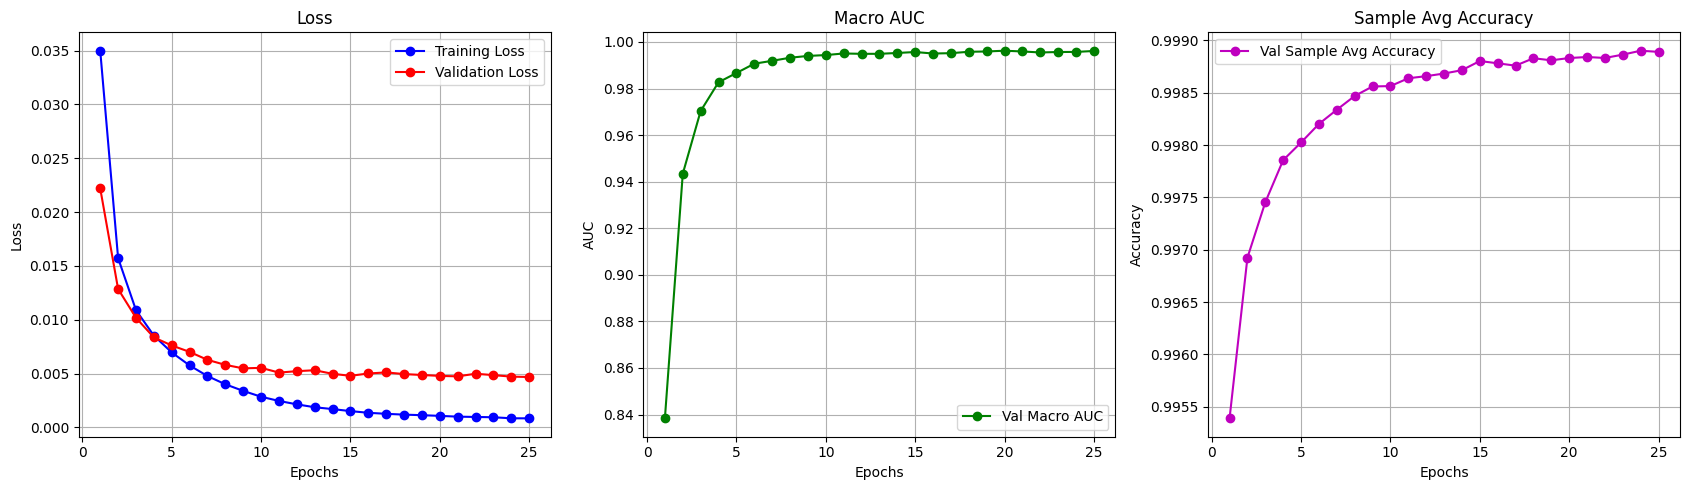

In [28]:
cfg.EPOCHS = 25
EXPERIMENT_NAME = "ENB0-SpecAugMild-RLROP-ES5-LR1e-3"

if 'optimizer' in globals():
  #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS, eta_min=1e-6)
  print(f"Scheduler initialized: {type(scheduler).__name__}")
else:
  scheduler = None
  print("Optimizer not found, proceed without LR scheduler")

print(f"\nStarting training: {cfg.EPOCHS} epochs, BS={cfg.BATCH_SIZE}, Workers={cfg.NUM_WORKERS}")


# Train
#if 'dataloaders' in globals() and dataloaders is not None and 'model' in globals() and 'criterion' in globals() and 'optimizer' in globals() and 'scaler' in globals():
trained_model, training_history = run_training_pipeline(
      model,
      dataloaders,
      loss_func,
      optimizer,
      scaler,
      scheduler,
      num_epochs=cfg.EPOCHS,
      device=device,
      early_stopping_patience=5,
      experiment_name=EXPERIMENT_NAME,
      gsheet_worksheet_title="Epoch-logs"
  )
#else:
#  print("Error: Dataloaders not initialized, re-run the pipeline.")

# --- Plot Results ---
if 'training_history' in globals() and training_history['train_loss']:
    epochs_completed = len(training_history['train_loss'])
    epochs_range = range(1, epochs_completed + 1)
    plt.figure(figsize=(17, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, training_history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs_range, training_history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, training_history['val_macro_auc'], 'go-', label='Val Macro AUC')
    plt.title('Macro AUC'); plt.xlabel('Epochs'); plt.ylabel('AUC'); plt.legend(); plt.grid(True)
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, training_history['val_sample_avg_accuracy'], 'mo-', label='Val Sample Avg Accuracy')
    plt.title('Sample Avg Accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()
else:
    print("No training history to plot (training might have been interrupted or too short).")

In [29]:
torch.save(trained_model.state_dict(), '/content/drive/MyDrive/Kaggle/Bird_CLEF25/models/Zerointrained_model.pth')
